<a href="https://colab.research.google.com/github/Satish-Kumar-1/Emotion-Detection-System-Using-CNN/blob/main/Emotion_Detection_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"satishkumar0912","key":"dc71fffb70f2b880d42ad5a523a03bfc"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d msambare/fer2013

 86% 52.0M/60.3M [00:00<00:00, 78.0MB/s]
100% 60.3M/60.3M [00:00<00:00, 75.2MB/s]


In [ ]:
!unzip /content/fer2013.zip -d/content

In [ ]:
## Necessary packages
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL  import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,  img_to_array
from keras.utils import plot_model




## Setting up Directory to save model data

In [ ]:
project_name = 'FER_2013_Emotion_Detection'

model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

base_dir = '/content/'

project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok = True)

In [ ]:
for each_model in model_names:
    model_dir = os.path.join(project_dir, project_name)
    os.makedirs(model_dir, exist_ok = True)

print(f'Project directory structure created at: {project_dir}')

Project directory structure created at: /content/FER_2013_Emotion_Detection


## Data Cleaning

In [ ]:
## List of acceptable image extension
image_exts = ['jpeg' , 'jpg' , 'png']

data_dir = '/content/train'

for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)

        try:
            file_type = imghdr.what(file_path)

            if file_type not in image_exts:
                print(f'Image not ext list {file_path}')
                os.remove(file_path)

            else:
                img = cv2.imread(file_path)

        except Exception as e:
            print(f'Issue with file {file_path}. Error: {e}')
            os.remove(file_path)

## Data Analysis

In [ ]:
def count_files_in_subdirs(directory, set_name):
    counts = {}

    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)

        if os.path.isdir(item_path):
            counts[item] = len(os.listdir(item_path))

    df = pd.DataFrame(counts, index = [set_name])
    return df

train_dir = '/content/train'
test_dir = '/content/test'

train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

       disgust  neutral  angry  surprise  fear  happy   sad
train      436     4965   3995      3171  4097   7215  4830
      disgust  neutral  angry  surprise  fear  happy   sad
test      111     1233    958       831  1024   1774  1247


<Axes: >

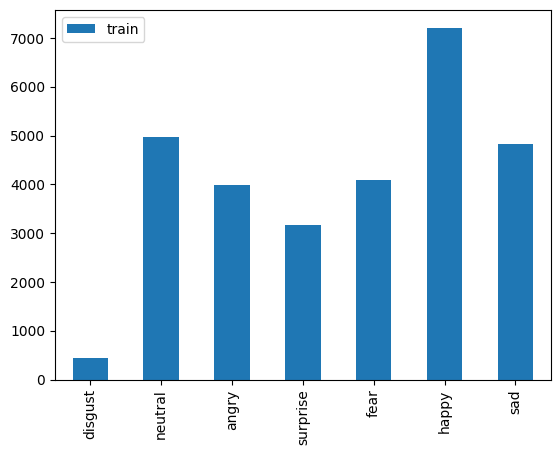

In [ ]:
train_count.transpose().plot(kind = 'bar')

<Axes: >

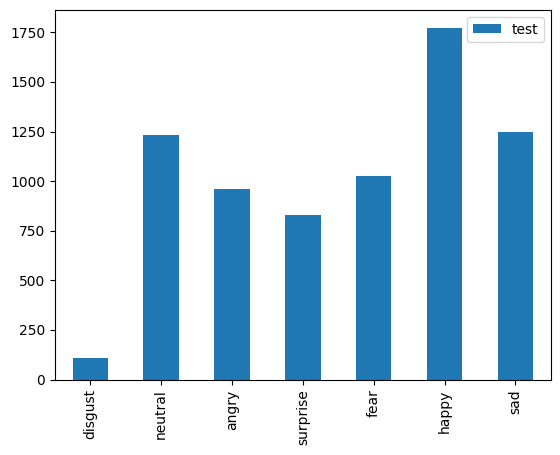

In [ ]:
test_count.transpose().plot(kind = 'bar')

## Plotting one image from each emotion

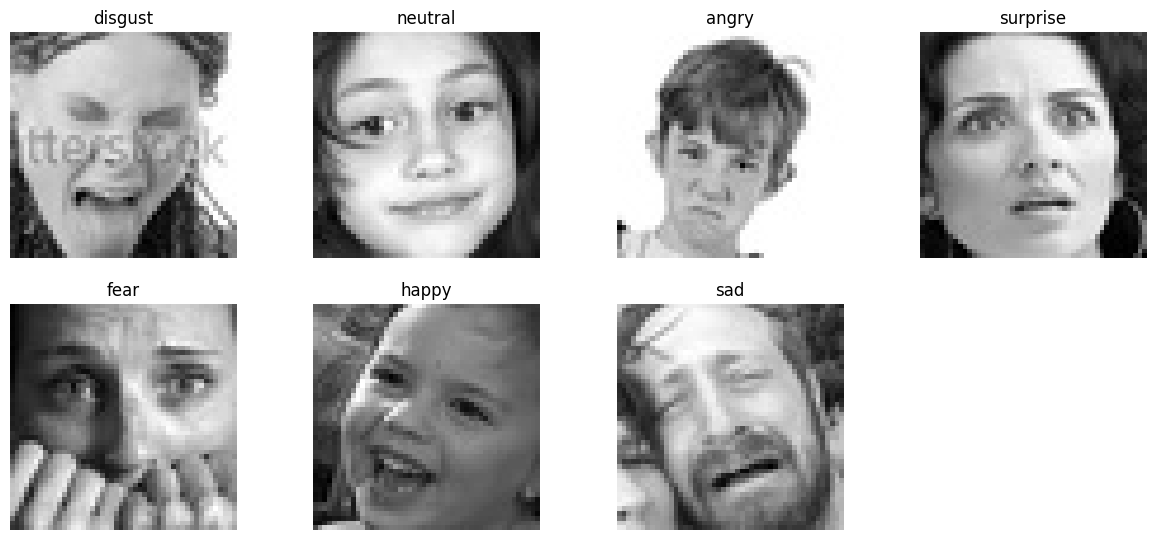

In [ ]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap = 'gray')
    plt.title(emotion)
    plt.axis('off')

## Plotting random images from given directory

In [ ]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    image_filenames = os.listdir(directory_path)

    if len(image_filenames) < num_images:
        print(f'Only found {len(image_filenames)} images in {directory_path}, displaying them all.')
        num_image = len(image_filenames)

    selected_images = random.sample(image_filenames, num_images)

    fig, axes = plt.subplots(3, 3, figsize=(5,5))
    axes = axes.ravel()

    for i,image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)

        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f'Image: {class_name}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

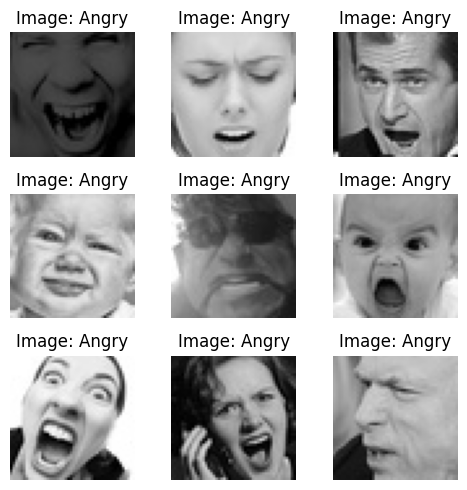

In [ ]:
angry_directory_path = '/content/train/angry'
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

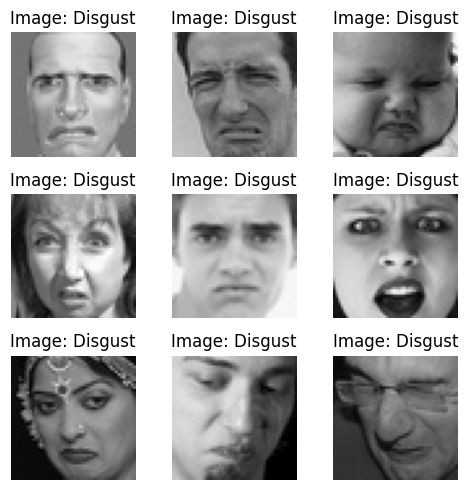

In [ ]:
disgust_directory_path = '/content/train/disgust'
plot_images_from_directory(disgust_directory_path, class_name = 'Disgust')

## Checking shapes and channels

In [ ]:
image =  '/content/train/angry/Training_10118481.jpg'

import cv2
img = cv2.imread(image)

if img is not None:
    print('Shape: ', img.shape)

else:
    print('Image could not be loaded')

Shape:  (48, 48, 3)


In [ ]:
image_path = '/content/train/angry/Training_10118481.jpg'

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if img is not None:
    print('Shape: ', img.shape)

else:
    print('The could is not avaialble')

Shape:  (48, 48)




## Custom CNN from scrathc



# Initializing the imagegenerators

In [ ]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

In [ ]:
img_width, img_height = 48, 48
batch_size = 64
epochs = 10
num_classes = 7


In [ ]:
data_generator  = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width , img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training'
)

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width , img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation'
)

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size = (img_width , img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    # subset = 'training'
)



Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
train_class_labels = train_generator.class_indices
print('Training class labels: ', train_class_labels)

validation_class_labels = validation_generator.class_indices
print('Validation class labels: ', validation_class_labels)

test_class_labels = test_generator.class_indices
print('Test class labels: ', test_class_labels)

Training class labels:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Test class labels:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (3, 3), kernel_initializer = 'glorot_uniform', padding = 'same' , input_shape=(img_width , img_height , 1) ))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same' ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size = (3, 3), padding = 'same' , kernel_regularizer = regularizers.l2(0.01) ))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size = (3, 3), kernel_regularizer = regularizers.l2(0.01) ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size = (3, 3), padding = 'same' , kernel_regularizer = regularizers.l2(0.01) ))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size = (3, 3), padding = 'same' , kernel_regularizer = regularizers.l2(0.01) ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

In [ ]:
!mkdir -p /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/

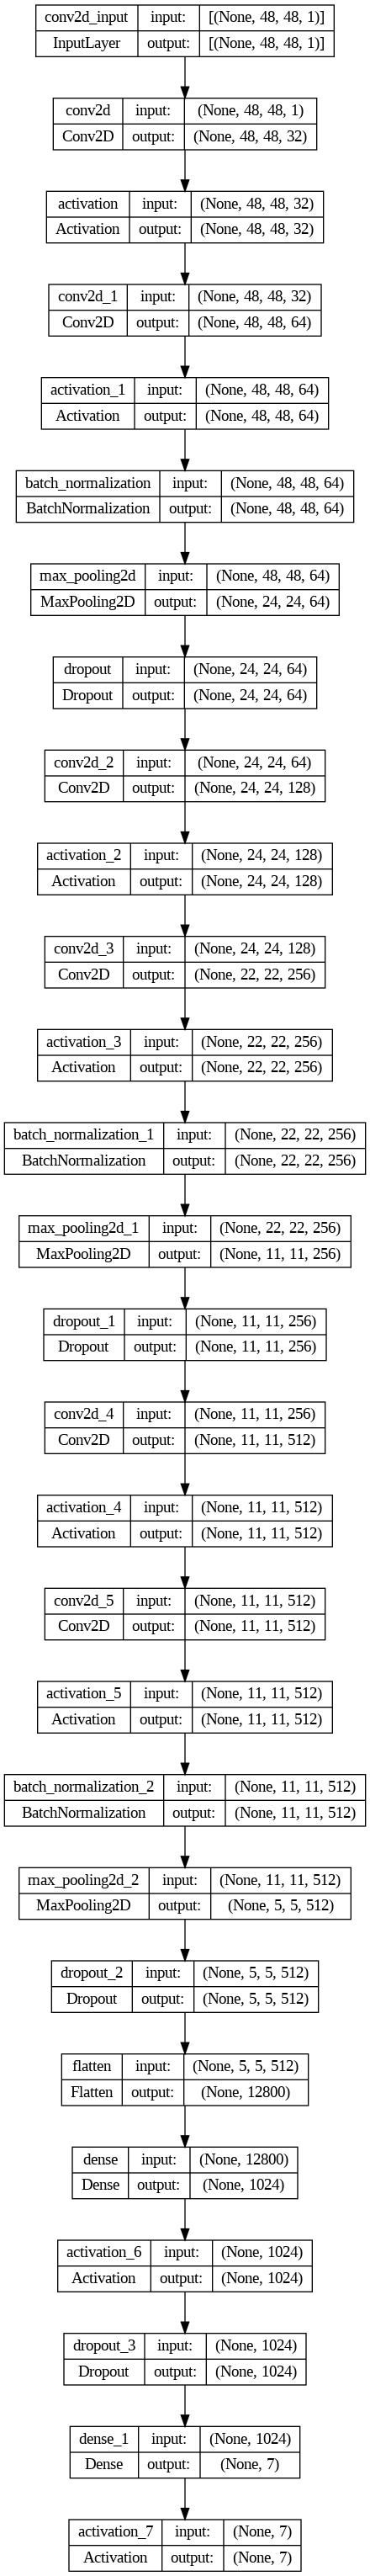

In [ ]:
plot_model(model, to_file = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Architecture.png',
              show_shapes = True , show_layer_names = True)


# Callbacks

In [ ]:
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

In [ ]:
## Checkpoint

checkpoint = ModelCheckpoint(filepath = chk_path,
                             save_best_only = True,
                             verbose = 1,
                             mode= 'min',
                             monitor = 'val_loss'
                             )

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 6,
                              verbose = 1,
                              min_delta = 0.0001

)

In [ ]:
csv_logger = CSVLogger(os.path.join(cnn_path, 'training_log'))

In [ ]:
callbacks = [checkpoint , earlystop , reduce_lr , csv_logger]

# Calculating Steps for epoch

In [ ]:
train_generator.samples

22968

In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1



# Model Training

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps_per_epoch,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps = validation_steps_epoch,
    callbacks = callbacks
)

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 12.4399 - accuracy: 0.2655
Epoch 1: val_loss improved from inf to 17.65957, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 [==============================] - 41s 86ms/step - loss: 12.4399 - accuracy: 0.2655 - val_loss: 17.6596 - val_accuracy: 0.1104 - lr: 1.0000e-04
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 10.1941 - accuracy: 0.3467
Epoch 2: val_loss improved from 17.65957 to 9.44330, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 [==============================] - 24s 68ms/step - loss: 10.1941 - accuracy: 0.3467 - val_loss: 9.4433 - val_accuracy: 0.3921 - lr: 1.0000e-04
Epoch 3/10
359/359 [==============================] - ETA: 0s - loss: 8.1609 - accuracy: 0.3910
Epoch 3: val_loss improved from 9.44330 to 7.22314, saving model to /content/FER_2013_Emotion_Detection/Cus

Plot the performance metrics

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize = (20 , 5))

    plt.subplot(1, 2 , 1)
    plt.plot(epochs_range , acc , label = 'Training_accuracy')
    plt.plot(epochs_range , val_acc , label = 'validation_accuracy')
    plt.legend(loc= 'lower right')
    plt.title('Training and Validation accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label = 'Training_loss')
    plt.plot(epochs_range, val_loss, label = 'validation Loss')
    plt.legend(loc = 'upper right')
    plt.title('Training and Validation loss')

    plt.show()


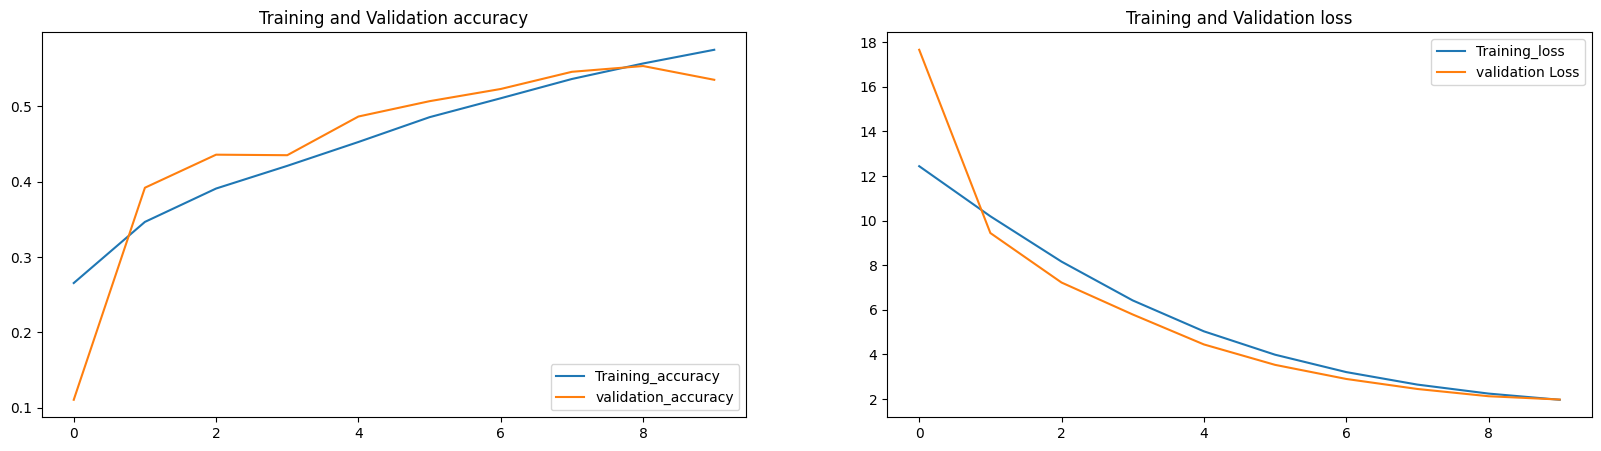

In [ ]:
plot_training_history(history)

In [ ]:
## Model evaluation

train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print('Final train accuracy ={:2f}, validation accuracy = {:2f}'. format(train_accu*100, test_accu*100))


113/113 [==============================] - 3s 26ms/step - loss: 1.9491 - accuracy: 0.5504
Final train accuracy =61.381054, validation accuracy = 55.043185


# Confusion Matrics

113/113 [==============================] - 2s 20ms/step


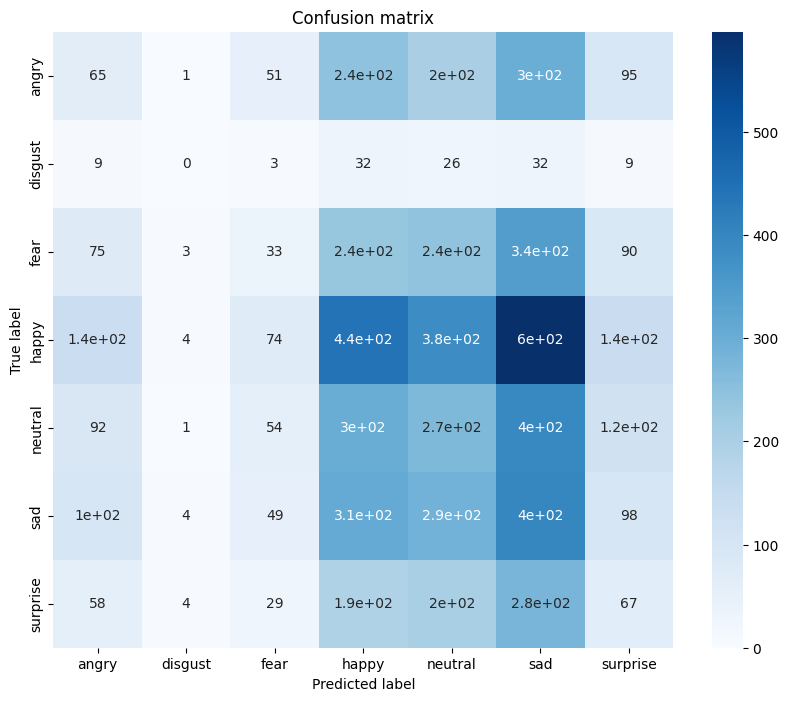

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator,  steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, cmap = 'Blues', xticklabels = class_labels, yticklabels= class_labels)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
## Printing the classification report

report = classification_report(true_classes, predicted_classes, target_names = class_labels)
print('Classification Report:\n', report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.12      0.07      0.09       958
     disgust       0.00      0.00      0.00       111
        fear       0.11      0.03      0.05      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.17      0.22      0.19      1233
         sad       0.17      0.32      0.22      1247
    surprise       0.11      0.08      0.09       831

    accuracy                           0.18      7178
   macro avg       0.13      0.14      0.13      7178
weighted avg       0.17      0.18      0.16      7178



# Making Prediction

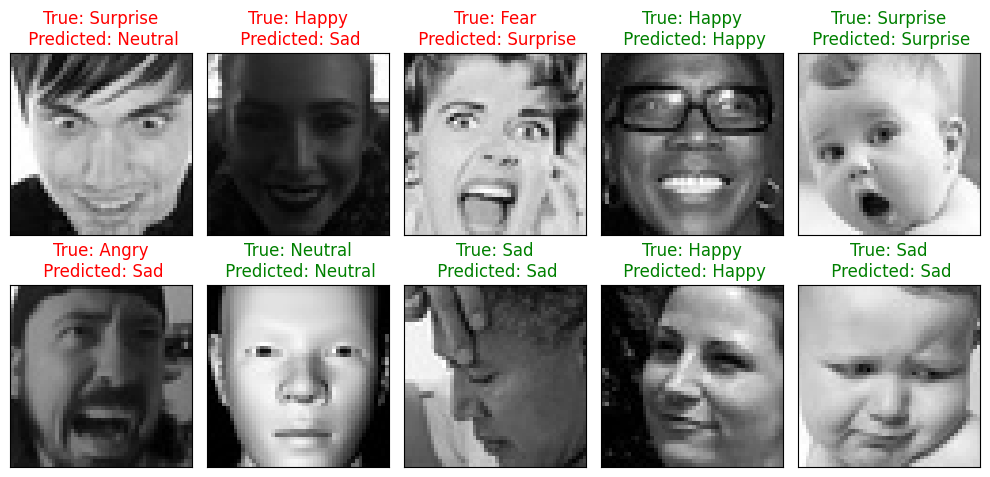

In [ ]:
Emotion_classes = ['Angry' , 'Disgust' , 'Fear' , 'Happy' , 'Neutral' , 'Sad' , 'Surprise']
batch_size = test_generator.batch_size

Random_batch = np.random.randint(0, len(test_generator)-1)

Random_img_index = np.random.randint(0, batch_size , 10)

fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize=(10, 5), subplot_kw = {'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    Random_img = test_generator[Random_batch][0][Random_img_index[i]]
    Random_img_label = np.argmax(test_generator[Random_batch][1][Random_img_index[i]], axis=0)

    model_prediction = np.argmax(model.predict(tf.expand_dims(Random_img, axis=0), verbose= 0), axis=1)[0]

    ax.imshow(Random_img.squeeze(), cmap = 'gray')
    color = 'green' if Emotion_classes[Random_img_label] ==  Emotion_classes[model_prediction] else 'red'

    ax.set_title(f'True: {Emotion_classes[Random_img_label]}\n Predicted: {Emotion_classes[model_prediction]}', color = color)

plt.tight_layout()
plt.show()

#''''Model 2: Image Augmentation''''

In [ ]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

img_width, img_height = 48, 48
batch_size = 64
epochs = 10
num_classes = 7

In [ ]:
data_generator  = ImageDataGenerator(rescale = 1./255,
                                     validation_split = 0.2,
                                     rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest'
                                     )

In [ ]:
test_data_generator = ImageDataGenerator(rescale = 1./255)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width , img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training'
)

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width , img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation'
)

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size = (img_width , img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    # subset = 'training'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


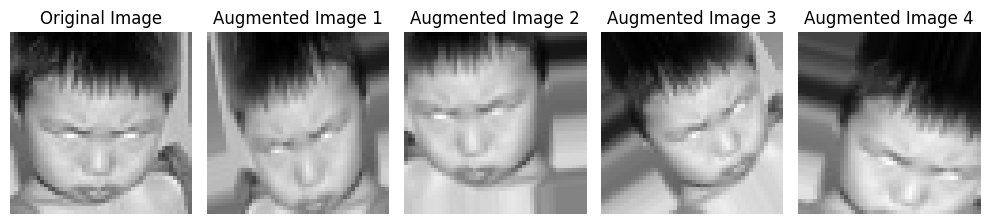

In [ ]:
image_path = '/content/train/angry/Training_10118481.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch

    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Construction of CNN model to train augmented data

In [ ]:
img_width, img_height = 48, 48
classes = 7



model = tf.keras.models.Sequential()

model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same' , input_shape=(img_width , img_height , 1) ))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same' ))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size = (3, 3), padding = 'same' , kernel_regularizer = regularizers.l2(0.01) ))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size = (3, 3), kernel_regularizer = regularizers.l2(0.01) ))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size = (3, 3), padding = 'same' , kernel_regularizer = regularizers.l2(0.01) ))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size = (3, 3), padding = 'same' , kernel_regularizer = regularizers.l2(0.01) ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(tf.keras.layers.Activation('relu'))

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_with_augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath = chk_path,
                             save_best_only = True,
                             verbose = 1,
                             mode= 'min',
                             monitor = 'val_loss'
                             )

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 6,
                              verbose = 1,
                              min_delta = 0.0001

)

csv_logger = CSVLogger(os.path.join(cnn_path, 'training_log'))

callbacks = [checkpoint , earlystop , reduce_lr , csv_logger]

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps_per_epoch,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = validation_steps_epoch,
    callbacks = callbacks
)

Epoch 1/100
359/359 [==============================] - ETA: 0s - loss: nan - accuracy: 0.1392
Epoch 1: val_loss did not improve from inf
359/359 [==============================] - 28s 77ms/step - loss: nan - accuracy: 0.1392 - val_loss: nan - val_accuracy: 0.1392 - lr: 1.0000e-04
Epoch 2/100
359/359 [==============================] - ETA: 0s - loss: nan - accuracy: 0.1392
Epoch 2: val_loss did not improve from inf
359/359 [==============================] - 40s 112ms/step - loss: nan - accuracy: 0.1392 - val_loss: nan - val_accuracy: 0.1392 - lr: 1.0000e-04
Epoch 3/100
359/359 [==============================] - ETA: 0s - loss: nan - accuracy: 0.1392
Epoch 3: val_loss did not improve from inf
Restoring model weights from the end of the best epoch: 1.
359/359 [==============================] - 48s 134ms/step - loss: nan - accuracy: 0.1392 - val_loss: nan - val_accuracy: 0.1392 - lr: 1.0000e-04
Epoch 3: early stopping


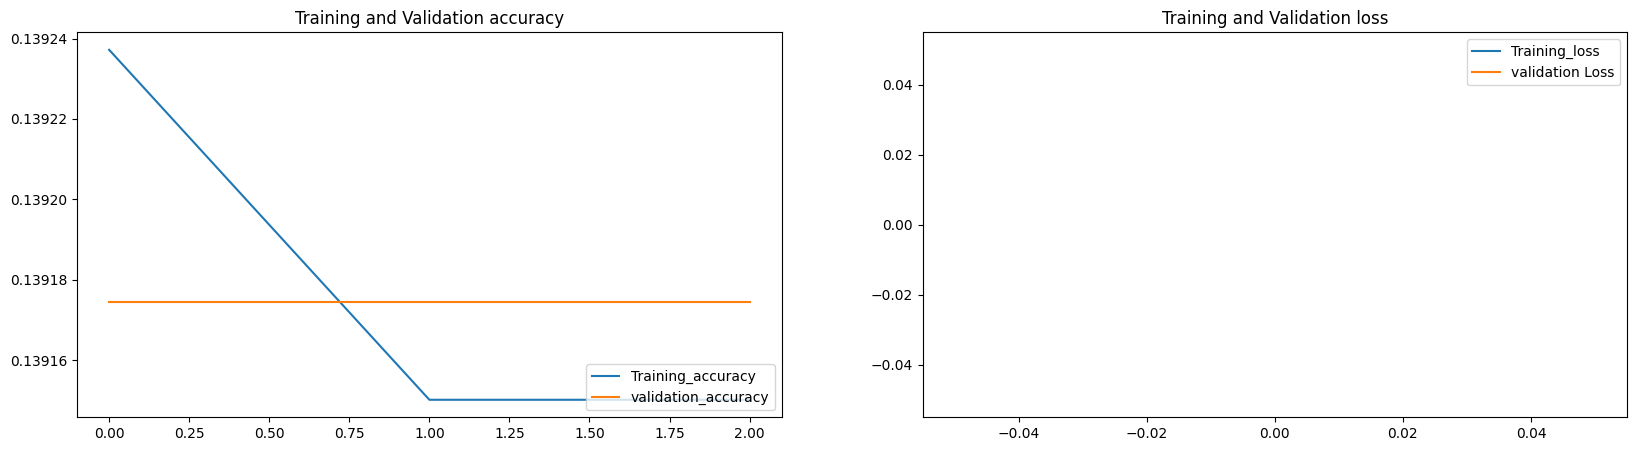

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print('Final train accuracy = {:2f}, validation  accuracy = {:.2f}'.format(train_accu*100, test_accu*100))

113/113 [==============================] - 6s 55ms/step - loss: nan - accuracy: 0.1335
Final train accuracy = 13.915013, validation  accuracy = 13.35
